# Compute Aij for the analysis of AE sensor surface
2021.09.23 Kurama Okubo

- 2022.11.23 update for new ball-drop test
- 2024.1.24 update for master plot; compute only the case 2 with the threshold of multiple incident waves due to the large azimuth
- 2024.1.26 update to compute the P amplitude of raw observation data in [V] to estimate the emperical gain.

**UPDATED**
1. the incident angle is computed in 3d, not 2d as in previous work on directionality.
2. Re-define Azimuth $\alpha$, incidence angle $\theta$ and dip $\delta$.
3. 2021.12.7 add threshold in incidence angle $\theta$ to avoid multiple incident waves from reflection.


In [1]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from glob import glob
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings

from IPython.display import display, Markdown

plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True
plt.rcParams['axes.linewidth'] = 0.75

from obspy.core.utcdatetime import UTCDateTime    
UTCDateTime.DEFAULT_PRECISION = 8 # increase the time precision

In [2]:
figdir = "../figure/debug_p06_surfaceeffect"
if not os.path.exists(figdir):
    os.makedirs(figdir)

# Geometry of model

<img src="geometry_of_model_incidenceangle.png" alt="drawing" width="600"/>


# Definision of angles for 4m friction experiments


In this condition, we need to choose free parameter as $\alpha, \eta, h$. The total derivative is then identical to the sum of partial derivatives such that

$$ d\theta = \dfrac{\partial \theta}{\partial \alpha} d\alpha + \dfrac{\partial \theta}{\partial h} dh + \dfrac{\partial \theta}{\partial \eta} d\eta. $$

When source is align on the middle of fault surface, $dh = d\eta = 0$. Thus,

$$ \dfrac{d\theta}{d\alpha} = \dfrac{\partial \theta}{\partial \alpha}.  $$

Then,
$$ \dfrac{d\theta}{d\alpha} = \dfrac{\cos^3 \theta}{\sin \theta} \dfrac{\sin \alpha}{\cos^3 \alpha} $$

<img src="derivation_sensitivityofincidentangle_correct.jpg" alt="drawing" width="400"/>

Threfore,
$$ \dfrac{d\alpha}{d\theta} = \dfrac{\sin \theta}{\cos^3 \theta} \dfrac{\cos^3 \alpha}{\sin \alpha} $$


debug orthogonal:54.46232220802562


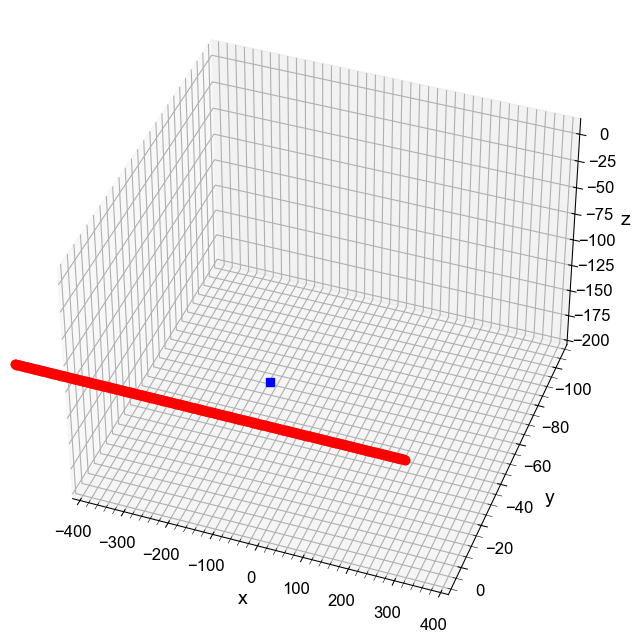

In [3]:
def compute_derivativeofazimuth3(alpha, eta, h):
    l = eta/np.cos(alpha)
    r = np.sqrt(h**2+l**2)
    costheta=eta/r
    sintheta=np.sqrt(1-costheta**2)
    return (costheta**3*np.sin(alpha))/(sintheta*np.cos(alpha)**3) # 1/delthetaalpha

xi = np.linspace(-400, 400, 600) #mm
eta = 50 * np.ones(len(xi))
h = 70 # height [mm]
theta = []
alpha=[]
delalpha=[]
    
print("debug orthogonal:{}".format(np.degrees(np.arctan(h/50)))) # alpha = 0

for i, xi1 in enumerate(xi):
    eta1 = eta[i]
    r1 = np.linalg.norm([xi1, eta1, h], ord=2)
    theta1 = np.arccos(np.abs(eta1)/r1)
    theta.append(theta1)
    alpha1 = np.arctan(xi1/(r1*np.cos(theta1)))
    alpha.append(alpha1)
    delalpha.append(compute_derivativeofazimuth3(alpha1, eta1, h))

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("x", size = 14)
ax.set_ylabel("y", size = 14)
ax.set_zlabel("z", size = 14)
ax.plot(xi, eta, np.zeros(len(xi)), "o", color = "red")
ax.plot(0, 0, -70, "s", color = "blue")

ax.set_xlim([-400, 400])
ax.set_ylim([-110, 10])
ax.set_zlim([-200, 10])

ax.invert_xaxis()

ax.view_init(40, 110)

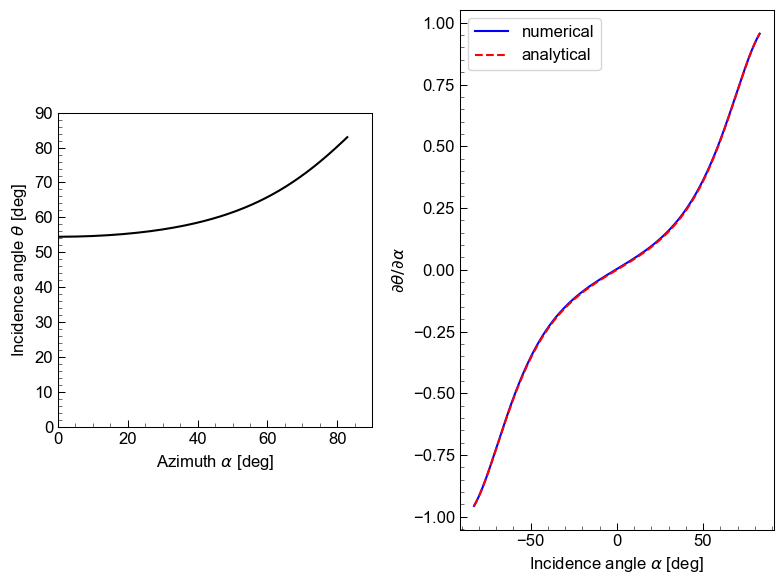

In [4]:
# validate the analytical estimation of dtheta/dalpha to the numerical one.
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 6))
ax1.set_aspect('equal')
ax1.plot(np.degrees(alpha),np.degrees(theta), 'k-')
# ax1.plot(alpha,theta, 'k-')
ax1.set_xlim(0, 90)
ax1.set_ylim(0, 90)
# ax1.set_xticks([40, 50, 60, 70, 80, 90])
ax1.set_ylabel(r"Incidence angle $\theta$ [deg]")
ax1.set_xlabel(r"Azimuth $\alpha$ [deg]")

# ax2.plot(alpha,delalpha, 'k-')
ax2.plot(np.degrees(alpha[0:-1]),np.diff(np.degrees(theta))/np.abs(np.diff(np.degrees(alpha))), 'b-', label="numerical")
ax2.plot(np.degrees(alpha),delalpha, 'r--', label="analytical")
ax2.legend(loc=2)
# ax2.set_xlim(0, 90)

ax2.set_xlabel(r"Incidence angle $\alpha$ [deg]")
ax2.set_ylabel(r"$\partial\theta / \partial\alpha$")

fig.tight_layout()
# ax1.set_ylim(0, 90)

In [5]:
# np.degrees(alpha)

In [6]:
int(np.floor(11/2))

5

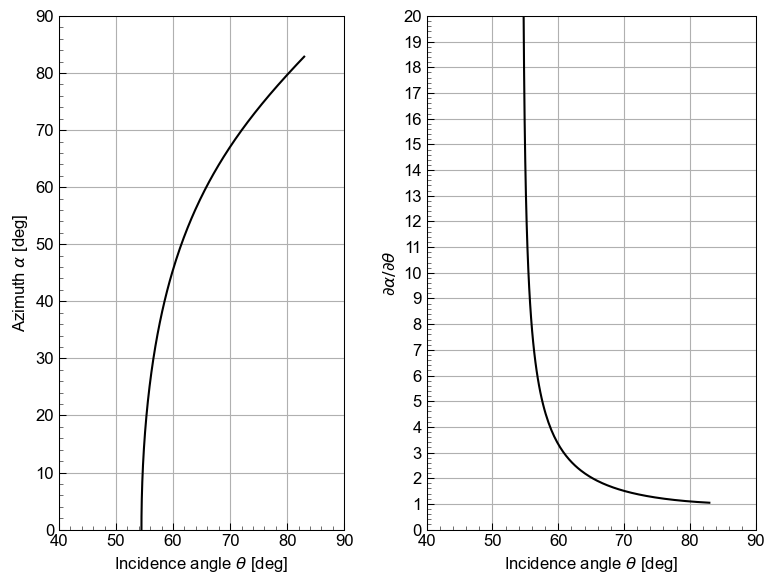

In [7]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 6), sharex=True)
ax1.set_aspect('equal')
ax1.plot(np.degrees(theta), np.degrees(alpha),'k-')
ax1.set_xlim(40, 90)
ax1.set_ylim(0, 90)
ax1.set_xticks([40, 50, 60, 70, 80, 90])
ax1.set_xlabel(r"Incidence angle $\theta$ [deg]")
ax1.set_ylabel(r"Azimuth $\alpha$ [deg]")
ax1.grid(True)
Nhalf = int(np.ceil(len(theta)/2))
ax2.plot(np.degrees(theta[Nhalf:]),1/np.array(delalpha[Nhalf:]), 'k-')
# ax2.plot(alpha,delalpha, 'k-')
# ax2.plot(np.degrees(alpha[0:-1]),np.diff(np.degrees(theta))/np.abs(np.diff(np.degrees(alpha))), 'b+--')
ax2.set_xlim(40, 90)
ax2.set_ylim(0, 20)
ax2.set_yticks(np.linspace(0, 20,21))
ax2.grid(True)

ax2.set_xlabel(r"Incidence angle $\theta$ [deg]")
ax2.set_ylabel(r"$\partial\alpha / \partial\theta$")

fig.tight_layout()
plt.savefig(figdir+"/incidenceangle_sensitivity.png", format="png", dpi=150)

## Bell curve fitting and cosine model

The vertical component of incident wave is 
$$ u_v = u \cos \theta = u \dfrac{l}{r} \cos\alpha $$

Therefore, The range of amplitude with respect to $\alpha$ depends on $\dfrac{l}{r}$.

# Evaluate interference of reflection wave

Reflection waves cause multiple incidence angle, which perturbe the convergence of models.
We thus decided to avoid those source-receiver pairs with compiting arrival time difference of P and Pp wave.




# Start processing data

In [8]:
#Parameters

pwin_len_pre = 5e-3 #[ms]: buffer of p window length to estimate gain
pwin_len = 1.5e-2 #[ms]: p window length to estimate gain

dist_p_threshold = 200 #300 #[mm]: use tpick within this threshold, otherwise use theoretical p arrival 

fontsize = 12
vmean = 6200

In [9]:
# Directory for picked waveforms
bdwaveform_datadir = "../data/DATA_greencomparison"

# channel table
channel_finame = '../../../Experiments/DetectEvent/data/AEsensorlocation_onFB03_table.csv'#'../data/array_32ch_all.csv'

# balldrop isocoord location
isoloc_finame = '../data/balldrop_events_isocoord.csv'

# Data outputdir
# outdir = "../data/DATA_surfaceeffect_Aij_theta70" This is defined later for case 1 and case 2


In [10]:
# if not os.path.exists(outdir):
#     os.makedirs(outdir)

In [11]:
# Read Channel Index
df_array = pd.read_csv(channel_finame)

channel_loc={}

for i in range(len(df_array)):
    stnm = df_array.iloc[i].Instrument_Label
    xtemp = df_array.iloc[i].North.astype('float')
    ytemp = df_array.iloc[i].East.astype('float')
    ztemp = df_array.iloc[i].Down.astype('float')
    channel_loc[stnm] = [xtemp, ytemp, ztemp]
    
AEsensors = list(channel_loc.keys())

In [12]:
# Read  isocoord ball-drop location
df_location = pd.read_csv(isoloc_finame, index_col=0)
stations = np.unique(df_location.OL)
datacases = np.unique(df_location.datacase)

In [13]:
print(len(stations), len(datacases))

32 32


In [14]:
datacases

array(['BD_0220', 'BD_0340', 'BD_0460', 'BD_0580', 'BD_0700', 'BD_0820',
       'BD_0940', 'BD_1060', 'BD_1180', 'BD_1300', 'BD_1420', 'BD_1540',
       'BD_1660', 'BD_1780', 'BD_1900', 'BD_2020', 'BD_2140', 'BD_2260',
       'BD_2380', 'BD_2500', 'BD_2620', 'BD_2740', 'BD_2860', 'BD_2980',
       'BD_3100', 'BD_3220', 'BD_3340', 'BD_3460', 'BD_3580', 'BD_3700',
       'BD_3820', 'BD_3940'], dtype=object)

## Compute amplitude from p window

In [15]:
# define freqband
freqmin = 0.01e6 
freqmax = 0.4e6 #1.0e6
freqband = '{:.2f}-{:.2f}'.format(freqmin/1e6, freqmax/1e6)


In [16]:
df_amp = pd.DataFrame(columns=['dist', 'incidentangle', 'Asyn', 'Aobs'])

# for stnm in tqdm(AEsensors):
stnm = AEsensors[3]
finame = os.path.join(bdwaveform_datadir, "{}_bdwaveform.pickle".format(stnm)) 

st = read(finame, format="PICKLE")

#Prefiltering
# demean
st.detrend(type='demean')
# apply bandpass
st.filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)
# apply taper
st.taper(max_percentage=0.001)   

st_obs = st.select(channel='OY')
st_syn = st.select(channel='SY')

In [17]:
st_obs[0].stats.dataindex

'OL04__BD_0580'

## UPDATE: compute incident angle in 3d

The backazimuth of source, i.e., incident angle, is computed as follows:
$$ \theta=\arccos \left( \dfrac{\mathbf{x} \cdot \mathbf{n}}{|\mathbf{x}|} \right)$$
$$ \mathbf{x} = (\xi, \eta, -z_{rec}) $$
$$ \mathbf{n} = (0, -1, 0) $$
where $\mathbf{x}$ is the source vector, and $\mathbf{n}$ is normal vector of receiver from side surface. Iso-coordinates are used in this representation.


In [18]:
tr_obs = st_obs[3]
# for tr_obs in st_obs:
dataindex = tr_obs.stats.dataindex
tr_syn = list(filter(lambda tr: tr.stats.dataindex == dataindex, st_syn))[0]

In [19]:
rx, ry, rz = [0.0, 0.0, 70.0e-3] # location of receiver sensor
nvec = [0, -1, 0]
print(np.linalg.norm(nvec, ord=2))

df_loc_tmp = df_location[df_location.index == dataindex]
xi1, eta1 = df_loc_tmp.xi1.values[0], df_loc_tmp.eta1.values[0]
st_x = tr_syn.stats.sac["user0"]*1e3
st_y = tr_syn.stats.sac["user1"]*1e3
st_z = tr_syn.stats.sac["user2"]*1e3
print('debug: st_x, xi1 = {}, {} st_z, eta1 = {}, {}, st_y = {}'.format(st_x, xi1, st_z, eta1, st_y))

1.0
debug: st_x, xi1 = 0.025999999706982635, 0.026 st_z, eta1 = 0.05500000042957254, -0.055, st_y = 0.0009999999974752427


In [20]:
# compute incident angle
rx, ry, rz = [0.0, 0.0, 70.0e-3] 
xvec = (xi1, eta1, -rz)
rlen = np.linalg.norm(xvec, ord=2)
incidenceangle = np.rad2deg(np.arccos(np.dot(xvec, nvec)/rlen))

# compute azimuth
azimuth = np.rad2deg(np.arctan2(xi1, np.abs(eta1)))

# compute length l
llen = np.linalg.norm([xi1, eta1], ord=2)

print(r"\theta, \alpha, r, l = {:4.2f} {:4.2f} {:4.2f} {:4.2f}".format(incidenceangle, azimuth,rlen*1e3 ,llen*1e3 ))

\theta, \alpha, r, l = 53.63 25.30 92.74 60.84


In [21]:
# reference azimuch on the source at center
np.rad2deg(np.arctan(70/50))

54.46232220802562

0.026 -0.055 -0.07


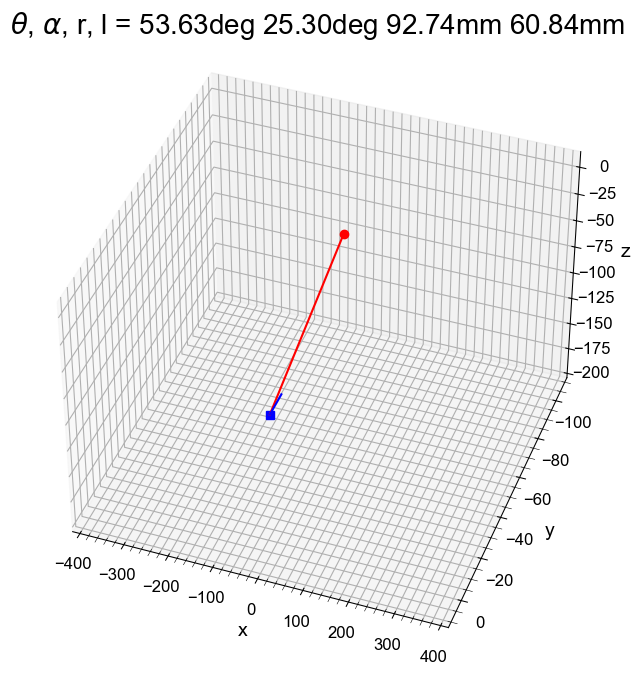

In [22]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_title(r"$\theta$, $\alpha$, r, l = {:4.2f}deg {:4.2f}deg {:4.2f}mm {:4.2f}mm".format(incidenceangle, azimuth,rlen*1e3 ,llen*1e3 ), size = 20)

ax.set_xlabel("x", size = 14)
ax.set_ylabel("y", size = 14)
ax.set_zlabel("z", size = 14)

ax.plot(xi1*1e3, eta1*1e3, 0*1e3, "o", color = "red")
ax.plot(0, 0, -70, "s", color = "blue")

ax.plot([0, xi1*1e3], [0, eta1*1e3], [-70, 0*1e3], "-", color = "red")
ax.plot([0, 0], [0, -10], [-70,-70], "-", color = "blue")

ax.set_xlim([-400, 400])
ax.set_ylim([-110, 10])
ax.set_zlim([-200, 10])

ax.invert_xaxis()

ax.view_init(40, 110)

# ax.plot(st_x*1e3, st_z*1e3, "o")
# ax.plot([0, c*np.sin(np.deg2rad(azimuth))], [0, c*np.cos(np.deg2rad(azimuth))], "r-")
print(xvec[0], xvec[1], xvec[2])

debug: azimuth on horizontal plane is 25.300975698803633 deg


(0.0, 100.0)

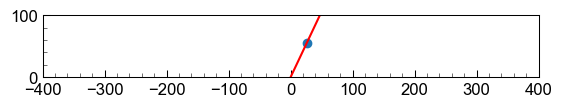

In [23]:
rx1, ry1, rz1 = [0.0, 70.0e-3, -1.0e-6] # location of receiver sensor
vec = np.array([rx1, rz1]) - np.array([st_x, st_z])
azimuth = np.rad2deg(np.arctan(vec[0]/vec[1]))
print("debug: azimuth on horizontal plane is {} deg".format(azimuth))

# debug plot
c = 1000
fig, ax = plt.subplots(1, 1)
ax.plot(st_x*1e3, st_z*1e3, "o")
ax.plot([0, c*np.sin(np.deg2rad(azimuth))], [0, c*np.cos(np.deg2rad(azimuth))], "r-")

ax.set_aspect('equal')
ax.set_xlim(-400, 400)
ax.set_ylim(0, 100)

In [24]:
# dist = tr_obs.stats.dist #[mm]
# #         p_theoretical = dist/vmean #[ms]
# if dist <= dist_p_threshold:
#     p_theoretical = tr_obs.stats.tpick
# else:
#     p_theoretical = dist/vmean

# #---Estimate gain---#
# st_tmp = tr_syn.stats.starttime
# pt = timedelta(milliseconds = tr_obs.stats.pretrigger)
# ps = timedelta(milliseconds = p_theoretical)
# pw = timedelta(milliseconds = pwin_len)

# starttime_tmp = st_tmp+pt+ps
# endtime_tmp  = st_tmp+pt+ps+pw

# p_max_obs = np.max(tr_obs.copy().trim(starttime_tmp, endtime_tmp).data) # avoid error in multiple trim
# p_max_syn = np.max(tr_syn.copy().trim(starttime_tmp, endtime_tmp).data) # avoid error in multiple trim
# #-------------------------#

# df_gain = df_gain.append(pd.DataFrame([[dist, azimuth, p_max_syn, p_max_obs]],
#                                    columns=['dist', 'incidentangle', 'Asyn', 'Aobs'],
#                                    index=[dataindex]))

In [25]:
np.radians(70)

1.2217304763960306

## Check the data before the removal of instrumental response
We compute the P wave amplitude of the data before the removal of instrumental response in the unit of voltage AEsensors to evaluate the emperical gain.

In [26]:
tr_obs.stats.origintime

0.08614901609209838

Text(0.5, 1.0, 'Comparison between observation in [V] and synthetics for OL08')

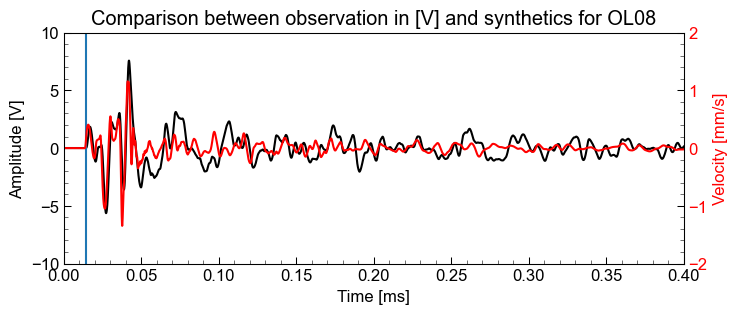

In [27]:
finame = os.path.join(bdwaveform_datadir, "{}_bdwaveform.pickle".format("OL08")) 
st = read(finame, format="PICKLE")
[tr_obs, tr_syn] = st.select(location="1900")

fig, ax = plt.subplots(1,1,figsize=(8,3))

obs_ot = 0.08695798828117168; # Note that data_noremoval is not trimmed.
ot_ind=int(np.round(tr_obs.stats.sampling_rate*obs_ot*1e-3))
Ndata = len(tr_obs.times())
p_theoretical = tr_obs.stats.tpick
tr_obs.data_noremoval=tr_obs.data_noremoval[ot_ind:ot_ind+tr_obs.stats.npts]
ax.plot(tr_obs.times()*1e3, tr_obs.data_noremoval, "k-")
ax.axvline(p_theoretical)
ax.set_xlim([0, 0.4])
ax.set_ylim([-10, 10])
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Amplitude [V]")
ax2 = ax.twinx()
ax2.plot(tr_syn.times()*1e3, tr_syn.data*1e3, "r-")
ax2.set_ylim([-2, 2])
ax2.set_ylabel('Velocity [mm/s]', color="r")
ax2.tick_params(axis='y', labelcolor="r")

plt.title("Comparison between observation in [V] and synthetics for OL08")

In [28]:
vmean = 6200;

df_amp = pd.DataFrame(columns=['incidenceangle', 'azimuth', 'rlen', 'llen', 'lr', 'delt_reflect', 'Asyn', 'Aobs', 'Aobs_noremoval'])
# rx, ry, rz = [0.0, 70e-3, 1.0e-3] # location of station
rx, ry, rz = [0.0, 0.0, 70.0e-3] # location of station in 3d coordinate
nvec = [0, -1, 0] # normal vector of station on the side surface

for stnm in tqdm(AEsensors):
# for stnm in tqdm(AEsensors[20:21]):
# stnm = AEsensors[8]
    finame = os.path.join(bdwaveform_datadir, "{}_bdwaveform.pickle".format(stnm)) 

    st = read(finame, format="PICKLE")

    #Prefiltering
    # demean
    st.detrend(type='demean')
    # apply bandpass
    st.filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)
    # apply taper
    st.taper(max_percentage=0.001)   

    st_obs = st.select(channel='OY')
    st_syn = st.select(channel='SY')

#     tr_obs = st_obs[5]
    for tr_obs in st_obs:
        
        dataindex = tr_obs.stats.dataindex

        tr_syn = list(filter(lambda tr: tr.stats.dataindex == dataindex, st_syn))[0]
        
        # compufreqbandte incident angle
        df_loc_tmp = df_location[df_location.index == dataindex]
        xi1, eta1 = df_loc_tmp.xi1.values[0], df_loc_tmp.eta1.values[0]
#         st_x = tr_syn.stats.sac["user0"]*1e3
#         st_y = tr_syn.stats.sac["user1"]*1e3
#         st_z = tr_syn.stats.sac["user2"]*1e3
#         print('debug: st_x, xi1 = {}, {} st_z, eta1 = {}, {}'.format(st_x, xi1, st_z, eta1))
#         vec = np.array([rx, rz]) - np.array([st_x, st_z])
#         azimuth = np.rad2deg(np.arctan(vec[0]/vec[1]))
#         print(azimuth)
    
        # compute incident angle
        xvec = (xi1, eta1, -rz)
        rlen = np.linalg.norm(xvec, ord=2)
        incidenceangle = np.rad2deg(np.arccos(np.dot(xvec, nvec)/rlen))
        
        # compute direct and reflected arrival time (2021.12.08)
        hw = 100e-3 # width of fault
        t_direct = rlen/vmean
        r_reflect = np.sqrt(rlen**2 + 4*hw**2 - 4*rlen*hw*np.cos(np.deg2rad(incidenceangle)))
        t_reflect = r_reflect/vmean
        delt_reflect = t_reflect - t_direct # This is used to threshold out the overlap of multiple P waves
        print(dataindex, rlen, r_reflect, t_direct, t_reflect, delt_reflect)
        
        # compute azimuth
        azimuth = np.rad2deg(np.arctan2(xi1, np.abs(eta1)))

        # compute length l
        llen = np.linalg.norm([xi1, eta1], ord=2)
        l_over_r = llen/rlen
        
        display(Markdown(r'$\theta$, $\alpha$, $r$, $l$, $l/r$ = {:4.2f} {:4.2f} {:4.2f} {:4.2f} {:4.2f}'.format(incidenceangle, azimuth,rlen*1e3,llen*1e3, l_over_r )))
        
        #---debug plot---#
#         c = 1000
#         fig, ax = plt.subplots(1, 1, figsize=(8, 3))
#         ax.plot(st_x*1e3, st_z*1e3, "o")
#         ax.plot([0, c*np.sin(np.deg2rad(azimuth))], [0, c*np.cos(np.deg2rad(azimuth))], "r-")
#         ax.set_aspect('equal')
#         ax.set_xlim(-400, 400)
#         ax.set_ylim(0, 100)
#         ax.set_xlabel("x [mm]")
#         ax.set_ylabel("y [mm]")
#         ax.set_title("{} {}".format(dataindex, azimuth))
        fig = plt.figure(figsize = (8, 8))
        ax = fig.add_subplot(111, projection='3d')

        ax.set_xlabel("x", size = 14)
        ax.set_ylabel("y", size = 14)
        ax.set_zlabel("z", size = 14)

        ax.plot(xi1*1e3, eta1*1e3, 0*1e3, "o", color = "red")
        ax.plot(0, 0, -70, "s", color = "blue")

        ax.plot([0, xi1*1e3], [0, eta1*1e3], [-70, 0*1e3], "-", color = "red")
        ax.plot([0, 0], [0, -10], [-70,-70], "-", color = "blue")

        ax.set_xlim([-400, 400])
        ax.set_ylim([-110, 10])
        ax.set_zlim([-200, 10])

        ax.invert_xaxis()

        ax.view_init(40, 110)
        
        ax.set_title(r"$\theta$, $\alpha$, r, l = {:4.2f}deg {:4.2f}deg {:4.2f}mm {:4.2f}mm".format(incidenceangle, azimuth,rlen*1e3,llen*1e3), size = 20)

        if not os.path.exists(figdir+"/debug_theta70"):
            os.makedirs(figdir+"/debug_theta70")

        plt.savefig(figdir+"/debug_theta70/debug_incidentangle_{}.png".format(dataindex), format="png", dpi=75)
        plt.close('all')
        #--------------------#

        dist = tr_obs.stats.dist #[mm]
#         p_theoretical = dist/vmean #[ms]
        if dist <= dist_p_threshold:
            p_theoretical = tr_obs.stats.tpick
        else:
            p_theoretical = dist/vmean
                
        #---Estimate gain---#
        st_tmp = tr_syn.stats.starttime
        pt = timedelta(milliseconds = tr_obs.stats.pretrigger)
        pb = timedelta(milliseconds = pwin_len_pre)
        ps = timedelta(milliseconds = p_theoretical)
        pw = timedelta(milliseconds = pwin_len)

        starttime_tmp = st_tmp+pt-pb+ps
        endtime_tmp  = st_tmp+pt-pb+ps+pw

        p_max_obs = np.max(tr_obs.copy().trim(starttime_tmp, endtime_tmp).data) # avoid error in multiple trim
        p_max_syn = np.max(tr_syn.copy().trim(starttime_tmp, endtime_tmp).data) # avoid error in multiple trim
        #-------------------------#
        
        # update to compute the P amplitude of observation before the removal of instrumental response
        st_ind = int((tr_obs.stats.origintime+tr_obs.stats.pretrigger-pwin_len_pre+p_theoretical)*tr_obs.stats.sampling_rate*1e-3)
        et_ind = int((tr_obs.stats.origintime+tr_obs.stats.pretrigger-pwin_len_pre+p_theoretical+pwin_len)*tr_obs.stats.sampling_rate*1e-3)
        tvec_data_noremoval_trimmed = tr_obs.times()[st_ind:et_ind] - tr_obs.stats.origintime*1e-3 # start from origintime
        data_noremoval_trimmed = tr_obs.copy().data_noremoval[st_ind:et_ind]
        p_max_obs_noremoval = np.max(data_noremoval_trimmed)
        #-------------------------#

        
        #---debug plot of pick P amplitude---#
        fig, ax = plt.subplots(3,1,figsize=(8,6))
        ax[0].plot(tr_obs.times(), tr_obs.data, "r-", label="obs")
        ax[0].axhline(p_max_obs, c='r', ls='--')
        xl = (pt.microseconds+ps.microseconds)*1e-6
        xr = xl + pwin_len*1e-3
        ax[0].axvline(xl, ls="--");
        ax[0].set_xlim([0.8*xl, 1.2*xr])
        ax[0].set_ylim(1.1*np.array([-p_max_obs, p_max_obs]))
        ax[0].set_title("pamp {:4.2e} [mm/s]".format(p_max_obs*1e3))
        ax[0].legend(loc=1)

        ax[1].plot(tr_syn.times(), tr_syn.data, "k-", label="syn")
        ax[1].axhline(p_max_syn, c='k', ls='--')
        ax[1].set_xlim([0.8*xl, 1.2*xr])
        ax[1].set_ylim(1.1*np.array([-p_max_syn, p_max_syn]))
        ax[1].set_title("pamp {:4.2e} [mm/s]".format(p_max_syn*1e3))
        ax[1].legend(loc=1)
        
        ax[2].plot(tvec_data_noremoval_trimmed, data_noremoval_trimmed, "b-", label="obs noremoval")
        ax[2].axhline(p_max_obs_noremoval, c='b', ls='--')
        ax[2].set_xlim([0.8*xl, 1.2*xr])
        ax[2].set_ylim(1.1*np.array([-p_max_obs_noremoval, p_max_obs_noremoval]))
        ax[2].set_title("pamp {:4.2e} [V]".format(p_max_obs_noremoval))
        ax[2].legend(loc=1)       
        
        plt.tight_layout()
        plt.savefig(figdir+"/debug_theta70/debug_pamp_{}.png".format(dataindex), format="png", dpi=75)
        plt.close('all')
        #--------------------------#
        print("dist, llen = {:4.2f}, {:4.2f}".format(dist, llen))
        
        df_amp = pd.concat([df_amp, pd.DataFrame([[incidenceangle, azimuth, rlen*1e3, llen*1e3, l_over_r, delt_reflect, p_max_syn, p_max_obs, p_max_obs_noremoval]],
                                   columns=['incidenceangle', 'azimuth', 'rlen', 'llen', 'lr', 'delt_reflect', 'Asyn', 'Aobs', 'Aobs_noremoval'],
                                   index=[dataindex])])

  0%|                                                    | 0/32 [00:00<?, ?it/s]

OL01__BD_0220 0.09362157870918435 0.16237302731673142 1.5100254630513604e-05 2.6189197954311518e-05 1.1088943323797915e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 53.26 25.74 93.62 62.17 0.66

dist, llen = 93.62, 0.06
OL01__BD_0340 0.17176146249959565 0.22338755560684218 2.770346169348317e-05 3.603025090432938e-05 8.326789210846212e-06


/var/folders/6n/nsqc1sbn1kn5ccc7y51plgz00000gn/T/ipykernel_61598/4151155549.py:169: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_amp = pd.concat([df_amp, pd.DataFrame([[incidenceangle, azimuth, rlen*1e3, llen*1e3, l_over_r, delt_reflect, p_max_syn, p_max_obs, p_max_obs_noremoval]],


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 73.42 71.80 171.76 156.85 0.91

dist, llen = 171.76, 0.16
OL01__BD_0460 0.2812916635807041 0.31547583108694716 4.5369623158178087e-05 5.088319856241083e-05 5.5135754042327445e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 79.97 79.64 281.29 272.44 0.97

dist, llen = 281.29, 0.27
OL01__BD_0580 0.3969382823563381 0.4232729615744431 6.402230360586098e-05 6.826983251200696e-05 4.2475289061459734e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 83.35 83.24 396.94 390.72 0.98

  3%|█▍                                          | 1/32 [00:01<00:45,  1.48s/it]

dist, llen = 396.94, 0.39
OL02__BD_0220 0.21280272554645535 0.2507688178382631 3.4323020249428284e-05 4.04465835223005e-05 6.123563272872215e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 74.74 -73.82 212.80 200.96 0.94

dist, llen = 212.80, 0.20
OL02__BD_0340 0.11109455432198286 0.1809475062000027 1.7918476503545623e-05 2.9185081645161724e-05 1.1266605141616101e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 63.83 -55.39 111.09 86.27 0.78

dist, llen = 111.09, 0.09
OL02__BD_0460 0.09800510190801294 0.17321951391226106 1.580727450129241e-05 2.793863127617114e-05 1.213135677487873e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 60.00 44.41 98.01 68.59 0.70

dist, llen = 98.01, 0.07
OL02__BD_0580 0.18772320048411703 0.2384114091229696 3.027793556195436e-05 3.845345308434994e-05 8.17551752239558e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 75.82 74.69 187.72 174.18 0.93

dist, llen = 187.72, 0.17
OL02__BD_0700 0.30057278652599273 0.3321806737304264 4.8479481697740765e-05 5.357752802103652e-05 5.098046323295756e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 80.42 80.15 300.57 292.31 0.97

  6%|██▊                                         | 2/32 [00:03<00:50,  1.69s/it]

dist, llen = 300.57, 0.29
OL03__BD_0340 0.3128929529407781 0.3439505778451317 5.046660531302873e-05 5.54758996524406e-05 5.009294339411865e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 80.99 -80.75 312.89 304.96 0.97

dist, llen = 312.89, 0.30
OL03__BD_0460 0.201059692628831 0.24662724910277048 3.2428982682069515e-05 3.977858856496298e-05 7.349605882893465e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 75.89 -74.93 201.06 188.48 0.94

dist, llen = 201.06, 0.19
OL03__BD_0580 0.10421132376090422 0.18016658957753517 1.6808278025952293e-05 2.9059127351215352e-05 1.225084932526306e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 63.81 -53.43 104.21 77.20 0.74

dist, llen = 104.21, 0.08
OL03__BD_0700 0.1037496987947435 0.17539669324134932 1.673382238624895e-05 2.82897892324757e-05 1.1555966846226748e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 61.19 49.24 103.75 76.58 0.74

dist, llen = 103.75, 0.08
OL03__BD_0820 0.19758036339677076 0.24049532219982991 3.186780054786625e-05 3.878956809674676e-05 6.921767548880509e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 74.44 73.33 197.58 184.76 0.94

dist, llen = 197.58, 0.18
OL03__BD_0940 0.3090970721310702 0.33695845441240974 4.9854366472753254e-05 5.434813780845318e-05 4.493771335699928e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 79.75 79.47 309.10 301.07 0.97

  9%|████▏                                       | 3/32 [00:05<00:56,  1.96s/it]

dist, llen = 309.10, 0.30
OL04__BD_0580 0.34240327101241314 0.37261239914957206 5.522633403426018e-05 6.009877405638259e-05 4.872440022122407e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 82.28 -82.11 342.40 335.17 0.98

dist, llen = 342.40, 0.34
OL04__BD_0700 0.22878811157925144 0.26896839963088603 3.69013083192341e-05 4.338199994046549e-05 6.480691621231388e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 77.38 -76.73 228.79 217.82 0.95

dist, llen = 228.79, 0.22
OL04__BD_0820 0.12789839717525783 0.18750466660859405 2.062877373794481e-05 3.024268816267646e-05 9.613914424731649e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 65.52 -60.32 127.90 107.04 0.84

dist, llen = 127.90, 0.11
OL04__BD_0940 0.09274157643689264 0.16309812997088596 1.4958318780143975e-05 2.6306149995304187e-05 1.1347831215160212e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 53.63 25.30 92.74 60.84 0.66

dist, llen = 92.74, 0.06
OL04__BD_1060 0.1717789276948718 0.22069888989299424 2.7706278660463193e-05 3.559659514403133e-05 7.890316483568137e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 72.38 70.64 171.78 156.87 0.91

dist, llen = 171.78, 0.16
OL04__BD_1180 0.27935819300675613 0.31054951296049393 4.5057773065605826e-05 5.008863112266031e-05 5.030858057054484e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 78.85 78.48 279.36 270.45 0.97

 12%|█████▌                                      | 4/32 [00:07<00:57,  2.05s/it]

dist, llen = 279.36, 0.27
OL05__BD_0820 0.35405931706424565 0.37968144542497734 5.710634146197511e-05 6.123894281048021e-05 4.132601348505104e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 81.39 -81.22 354.06 347.07 0.98

dist, llen = 354.06, 0.35
OL05__BD_0940 0.24104149020448742 0.2758640969753042 3.8877659710401197e-05 4.449420918956519e-05 5.616549479163994e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 76.81 -76.20 241.04 230.65 0.96

dist, llen = 241.04, 0.23
OL05__BD_1060 0.13419388957773004 0.1928937531388718 2.1644175738343557e-05 3.111189566755997e-05 9.467719929216413e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 67.20 -62.99 134.19 114.49 0.85

dist, llen = 134.19, 0.11
OL05__BD_1180 0.08967162315916893 0.16260688792299055 1.4463165025672408e-05 2.6226917406933958e-05 1.176375238126155e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 52.97 15.52 89.67 56.04 0.62

dist, llen = 89.67, 0.06
OL05__BD_1300 0.16516960979550685 0.21744194627532198 2.664025964443659e-05 3.507128165731e-05 8.431022012873411e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 72.38 70.47 165.17 149.60 0.91

dist, llen = 165.17, 0.15
OL05__BD_1420 0.2719816170258571 0.3032721550027302 4.386800274610598e-05 4.8914863710117776e-05 5.0468609640117934e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 78.33 77.92 271.98 262.82 0.97

dist, llen = 271.98, 0.26
OL05__BD_1540 0.3919604571892425 0.4152505267907556 6.321942857891008e-05 6.69758914178638e-05 3.756462838953723e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 82.23 82.10 391.96 385.66 0.98

 16%|██████▉                                     | 5/32 [00:10<01:00,  2.24s/it]

dist, llen = 391.96, 0.39
OL06__BD_1060 0.3239567872417554 0.35234642044442566 5.225109471641216e-05 5.683006781361704e-05 4.578973097204882e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 80.76 -80.54 323.96 316.30 0.98

dist, llen = 323.96, 0.32
OL06__BD_1180 0.21410511437142274 0.2534580833195107 3.45330829631327e-05 4.0880336019275916e-05 6.347253056143218e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 75.39 -74.52 214.11 202.34 0.95

dist, llen = 214.11, 0.20
OL06__BD_1300 0.11027692415006868 0.1793348822733603 1.7786600669365916e-05 2.8924981011832308e-05 1.1138380342466392e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 63.04 -54.07 110.28 85.21 0.77

dist, llen = 110.28, 0.09
OL06__BD_1420 0.1006677704133751 0.16773192898193237 1.62367371634476e-05 2.705353693256974e-05 1.081679976912214e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 56.88 40.52 100.67 72.35 0.72

dist, llen = 100.67, 0.07
OL06__BD_1540 0.19311395599489956 0.23683960817397073 3.1147412257241865e-05 3.819993680225334e-05 7.0525245450114775e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 74.07 72.87 193.11 179.98 0.93

dist, llen = 193.11, 0.18
OL06__BD_1660 0.3015310929240963 0.3330480445821593 4.863404724582198e-05 5.371742654550957e-05 5.083379299687584e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 80.46 80.18 301.53 293.29 0.97

 19%|████████▎                                   | 6/32 [00:12<00:58,  2.25s/it]

dist, llen = 301.53, 0.29
OL07__BD_1300 0.3691625658161997 0.39532391781929915 5.95423493251935e-05 6.376192222891922e-05 4.2195729037257225e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 82.22 -82.07 369.16 362.47 0.98

dist, llen = 369.16, 0.36
OL07__BD_1420 0.25879335385592883 0.29150300169981097 4.174086352514981e-05 4.701661317738887e-05 5.275749652239054e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 77.73 -77.25 258.79 249.15 0.96

dist, llen = 258.79, 0.25
OL07__BD_1540 0.14708160999934697 0.20107958623390887 2.3722840322475318e-05 3.2432191328049816e-05 8.709351005574498e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 68.88 -65.81 147.08 129.36 0.88

dist, llen = 147.08, 0.13
OL07__BD_1660 0.08602906485601249 0.16553247415537536 1.3875655621937498e-05 2.66987861540928e-05 1.2823130532155303e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 54.47 -1.15 86.03 50.01 0.58

dist, llen = 86.03, 0.05
OL07__BD_1780 0.1437358688706476 0.20361728806759016 2.3183204656556064e-05 3.284149807541777e-05 9.658293418861705e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 70.49 67.52 143.74 125.54 0.87

dist, llen = 143.74, 0.13
OL07__BD_1900 0.254411084664171 0.28969811873741946 4.103404591357597e-05 4.6725503022164426e-05 5.691457108588459e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 78.21 77.73 254.41 244.59 0.96

dist, llen = 254.41, 0.24
OL07__BD_2020 0.37000135134888357 0.3966119009812994 5.967763731433606e-05 6.396966144859667e-05 4.2920241342606086e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 82.39 82.25 370.00 363.32 0.98

 22%|█████████▋                                  | 7/32 [00:15<01:00,  2.41s/it]

dist, llen = 370.00, 0.36
OL08__BD_1540 0.37832922171040395 0.4024089959233019 6.1020842211355475e-05 6.490467676182289e-05 3.883834550467418e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 81.95 -81.80 378.33 371.80 0.98

dist, llen = 378.33, 0.37
OL08__BD_1660 0.2653318676676437 0.3006675905381223 4.279546252703931e-05 4.8494772667439084e-05 5.699310140399772e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 79.14 -78.73 265.33 255.93 0.96

dist, llen = 265.33, 0.26
OL08__BD_1780 0.15861904047118683 0.21438283513378587 2.5583716205030133e-05 3.457787663448159e-05 8.994160429451457e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 72.39 -70.29 158.62 142.34 0.90

dist, llen = 158.62, 0.14
OL08__BD_1900 0.08789197915623473 0.16408839081421944 1.417612567036044e-05 2.6465869486164425e-05 1.2289743815803986e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 53.73 -11.94 87.89 53.15 0.60

dist, llen = 87.89, 0.05
OL08__BD_2020 0.1392874725163753 0.1995018796903929 2.2465721373608918e-05 3.2177722530708536e-05 9.712001157099618e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 69.40 65.99 139.29 120.42 0.86

dist, llen = 139.29, 0.12
OL08__BD_2140 0.24336187047275917 0.27645071893558176 3.925191459238051e-05 4.458882563477125e-05 5.336911042390743e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 76.45 75.84 243.36 233.08 0.96

dist, llen = 243.36, 0.23
OL08__BD_2260 0.3586153928653928 0.38497402509779804 5.7841192397644e-05 6.209258469319324e-05 4.251392295549239e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 81.82 81.66 358.62 351.72 0.98

 25%|███████████                                 | 8/32 [00:17<00:58,  2.44s/it]

dist, llen = 358.62, 0.35
OL09__BD_1780 0.3932683562149388 0.4188794576008711 6.343038003466755e-05 6.756120283885018e-05 4.130822804182633e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 82.99 -82.87 393.27 386.99 0.98

dist, llen = 393.27, 0.39
OL09__BD_1900 0.27518175811634027 0.30809901006007795 4.438415453489359e-05 4.969338871936741e-05 5.309234184473821e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 79.11 -78.73 275.18 266.13 0.97

dist, llen = 275.18, 0.27
OL09__BD_2020 0.16401524319403976 0.21748793069961378 2.645407148290964e-05 3.5078698499937705e-05 8.624627017028065e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 72.62 -70.71 164.02 148.33 0.90

dist, llen = 164.02, 0.15
OL09__BD_2140 0.09340770846134704 0.16101242188104622 1.5065759429249521e-05 2.5969745464684876e-05 1.0903986035435355e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 52.39 -22.83 93.41 61.85 0.66

dist, llen = 93.41, 0.06
OL09__BD_2260 0.13078608488673404 0.19158549005600609 2.1094529820440973e-05 3.0900885492904206e-05 9.806355672463233e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 67.05 62.51 130.79 110.48 0.84

dist, llen = 130.79, 0.11
OL09__BD_2380 0.23015864094141675 0.268650330355278 3.7122361442163994e-05 4.333069844439968e-05 6.208337002235687e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 76.94 76.28 230.16 219.26 0.95

dist, llen = 230.16, 0.22
OL09__BD_2500 0.3504340166136844 0.3789511841913152 5.652161558285232e-05 6.11211587405347e-05 4.599543157682379e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 82.13 81.96 350.43 343.37 0.98

 28%|████████████▍                               | 9/32 [00:20<00:56,  2.47s/it]

dist, llen = 350.43, 0.34
OL10__BD_2020 0.39925054790194087 0.42402948010722086 6.439524966160337e-05 6.839185163019691e-05 3.996601968593537e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 82.95 -82.84 399.25 393.07 0.98

dist, llen = 399.25, 0.39
OL10__BD_2140 0.2884874347350332 0.3168990375498165 4.653023140887632e-05 5.111274799190589e-05 4.582516583029572e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 78.60 -78.25 288.49 279.87 0.97

dist, llen = 288.49, 0.28
OL10__BD_2260 0.17494284781036348 0.22406472279232176 2.821658835651024e-05 3.613947141811641e-05 7.922883061606172e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 73.05 -71.45 174.94 160.33 0.92

dist, llen = 174.94, 0.16
OL10__BD_2380 0.09472592042308166 0.16784814565552997 1.5278374261787365e-05 2.7072281557343542e-05 1.1793907295556177e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 56.70 -35.43 94.73 63.82 0.67

dist, llen = 94.73, 0.06
OL10__BD_2500 0.12370933675353693 0.19001052602421797 1.9953118831215633e-05 3.064685903616419e-05 1.0693740204948554e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 67.17 61.93 123.71 102.00 0.82

dist, llen = 123.71, 0.10
OL10__BD_2620 0.22808989455914086 0.2646223724479848 3.678869267082917e-05 4.2681027814191095e-05 5.892335143361926e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 76.05 75.32 228.09 217.08 0.95

dist, llen = 228.09, 0.22
OL10__BD_2740 0.3414805997417716 0.3679796190008354 5.5077516087382514e-05 5.935155145174765e-05 4.2740353643651365e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 81.07 80.88 341.48 334.23 0.98

 31%|█████████████▍                             | 10/32 [00:22<00:54,  2.46s/it]

dist, llen = 341.48, 0.33
OL11__BD_2380 0.29040144627739034 0.321765442519858 4.6838942947966184e-05 5.189765201933193e-05 5.058709071365749e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 79.68 -79.37 290.40 281.84 0.97

dist, llen = 290.40, 0.28
OL11__BD_2500 0.1723484841824842 0.22473095024940382 2.7798142610078095e-05 3.624692745958126e-05 8.448784849503165e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 73.83 -72.26 172.35 157.49 0.91

dist, llen = 172.35, 0.16
OL11__BD_2620 0.09394147114027969 0.16378339354159202 1.5151850183916079e-05 2.6416676377676133e-05 1.1264826193760054e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 54.16 -28.61 93.94 62.65 0.67

dist, llen = 93.94, 0.06
OL11__BD_2740 0.1257338458808924 0.18603494295427409 2.0279652561434258e-05 3.0005635960366788e-05 9.72598339893253e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 65.07 59.51 125.73 104.45 0.83

dist, llen = 125.73, 0.10
OL11__BD_2860 0.22830900113661748 0.2670674072214728 3.682403244138992e-05 4.307538826152787e-05 6.251355820137953e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 76.83 76.16 228.31 217.31 0.95

dist, llen = 228.31, 0.22
OL11__BD_2980 0.34088267776465264 0.3695957250835026 5.4981077058814944e-05 5.961221372314558e-05 4.631136664330633e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 81.74 81.55 340.88 333.62 0.98

 34%|██████████████▊                            | 11/32 [00:25<00:52,  2.50s/it]

dist, llen = 340.88, 0.33
OL12__BD_2620 0.30335622624235026 0.3317001658124397 4.892842358747585e-05 5.350002674394189e-05 4.571603156466044e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 79.55 -79.26 303.36 295.17 0.97

dist, llen = 303.36, 0.30
OL12__BD_2740 0.1913347851280577 0.2353911638103691 3.0860449214202856e-05 3.796631674360792e-05 7.105867529405064e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 73.92 -72.68 191.33 178.07 0.93

dist, llen = 191.33, 0.18
OL12__BD_2860 0.10002499687578101 0.1708947044235134 1.6133064012222744e-05 2.7563662003792483e-05 1.1430597991569738e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 58.68 -43.30 100.02 71.45 0.71

dist, llen = 100.02, 0.07
OL12__BD_2980 0.1104581368664165 0.1805574700753198 1.781582852684137e-05 2.912217259279352e-05 1.1306344065952148e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 63.67 55.01 110.46 85.45 0.77

dist, llen = 110.46, 0.09
OL12__BD_3100 0.20426942992038724 0.24764086900186727 3.294668224522375e-05 3.994207564546246e-05 6.995393400238712e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 75.54 74.59 204.27 191.90 0.94

dist, llen = 204.27, 0.19
OL12__BD_3220 0.3204372013359248 0.3479655155327896 5.1683419570310454e-05 5.6123470247224127e-05 4.440050676913673e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 80.30 80.06 320.44 312.70 0.98

 38%|████████████████▏                          | 12/32 [00:28<00:51,  2.55s/it]

dist, llen = 320.44, 0.31
OL13__BD_2860 0.3114562569607488 0.3408885448354051 5.023488015495948e-05 5.498202336054921e-05 4.747143205589728e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 80.39 -80.13 311.46 303.49 0.97

dist, llen = 311.46, 0.30
OL13__BD_2980 0.19925109786397666 0.2451550529766825 3.213727384902849e-05 3.954113757688427e-05 7.403863727855782e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 75.76 -74.77 199.25 186.55 0.94

dist, llen = 199.25, 0.19
OL13__BD_3100 0.10828665661105251 0.17699152522084216 1.746558977597621e-05 2.8547020196910025e-05 1.1081430420933813e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 61.90 -51.88 108.29 82.62 0.76

dist, llen = 108.29, 0.08
OL13__BD_3220 0.10573551910309043 0.17198837169994954 1.7054115984369424e-05 2.7740059951604765e-05 1.0685943967235342e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 59.29 47.05 105.74 79.25 0.75

dist, llen = 105.74, 0.08
OL13__BD_3340 0.19944172081086745 0.2477438192972733 3.216801948562378e-05 3.9958680531818275e-05 7.790661046194493e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 76.67 75.74 199.44 186.75 0.94

dist, llen = 199.44, 0.19
OL13__BD_3460 0.31273790943855845 0.3443907664267438 5.0441598296541684e-05 5.554689781076513e-05 5.105299514223447e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 81.17 80.94 312.74 304.80 0.97

 41%|█████████████████▍                         | 13/32 [00:31<00:50,  2.67s/it]

dist, llen = 312.74, 0.30
OL14__BD_3100 0.32668945498745444 0.35542369082547104 5.269184757862168e-05 5.732640174604371e-05 4.634554167422031e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 81.02 -80.80 326.69 319.10 0.98

dist, llen = 326.69, 0.32
OL14__BD_3220 0.2113764414498456 0.2511573212152097 3.409297442739445e-05 4.0509245357291885e-05 6.4162709298974346e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 75.20 -74.29 211.38 199.45 0.94

dist, llen = 211.38, 0.20
OL14__BD_3340 0.10852188719332152 0.18269373278796405 1.7503530192471213e-05 2.9466731094832913e-05 1.19632009023617e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 64.92 -56.31 108.52 82.93 0.76

dist, llen = 108.52, 0.08
OL14__BD_3460 0.09902019995940223 0.1749428478103635 1.597099999345197e-05 2.8216588356510242e-05 1.2245588363058271e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 61.00 46.74 99.02 70.04 0.71

dist, llen = 99.02, 0.07
OL14__BD_3580 0.1901709757034443 0.23529768379650493 3.067273801668456e-05 3.7951239322016926e-05 7.278501305332363e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 74.13 72.90 190.17 176.82 0.93

dist, llen = 190.17, 0.18
OL14__BD_3700 0.30120590963658067 0.33395358958993093 4.8581598328480756e-05 5.3863482191924345e-05 5.281883863443588e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 80.83 80.57 301.21 292.96 0.97

 44%|██████████████████▊                        | 14/32 [00:34<00:52,  2.94s/it]

dist, llen = 301.21, 0.29
OL15__BD_3340 0.32981358371055614 0.361077553996368 5.3195739308154215e-05 5.8238315160704514e-05 5.042575852550299e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 81.98 -81.79 329.81 322.30 0.98

dist, llen = 329.81, 0.32
OL15__BD_3460 0.21634463247328325 0.2600096152068227 3.489429556020698e-05 4.193703471077785e-05 7.042739150570873e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 77.18 -76.44 216.34 204.71 0.95

dist, llen = 216.34, 0.20
OL15__BD_3580 0.11901680553602503 0.1826608879864543 1.9196258957423393e-05 2.9461433546202307e-05 1.0265174588778914e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 64.09 -57.30 119.02 96.25 0.81

dist, llen = 119.02, 0.10
OL15__BD_3700 0.09340770846134704 0.17182840277439584 1.5065759429249521e-05 2.771425851199933e-05 1.2648499082749808e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 59.08 39.09 93.41 61.85 0.66

dist, llen = 93.41, 0.06
OL15__BD_3820 0.18074844397670484 0.23552069972722145 2.9152974834952393e-05 3.798720963342282e-05 8.834234798470425e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 76.24 75.05 180.75 166.64 0.92

dist, llen = 180.75, 0.17
OL15__BD_3940 0.2937039325579418 0.32659148794786436 4.7371602025474486e-05 5.2676046443203926e-05 5.3044444177294394e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 80.40 80.11 293.70 285.24 0.97

 47%|████████████████████▏                      | 15/32 [00:38<00:53,  3.16s/it]

dist, llen = 293.70, 0.29
OL16__BD_3580 0.3422937335096861 0.369276319305747 5.520866669511066e-05 5.956069666221726e-05 4.352029967106597e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 81.26 -81.07 342.29 335.06 0.98

dist, llen = 342.29, 0.34
OL16__BD_3700 0.22743130831088318 0.2693046601899046 3.668246908240051e-05 4.3436235514500746e-05 6.753766432100234e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 77.82 -77.18 227.43 216.39 0.95

dist, llen = 227.43, 0.22
OL16__BD_3820 0.1211197754291181 0.19357169214531347 1.953544764985776e-05 3.1221240668598946e-05 1.1685793018741187e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 69.21 -64.21 121.12 98.84 0.82

dist, llen = 121.12, 0.10
OL16__BD_3940 0.0908955444452587 0.16929855285855222 1.4660571684719145e-05 2.7306218202992295e-05 1.264564651827315e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 57.38 32.32 90.90 57.98 0.64

 50%|█████████████████████▌                     | 16/32 [00:41<00:51,  3.19s/it]

dist, llen = 90.90, 0.06
OL17__BD_0220 0.10705138952858109 0.1840108692441835 1.7266353149771145e-05 2.9679172458739274e-05 1.2412819308968128e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 65.73 57.09 107.05 80.99 0.76

dist, llen = 107.05, 0.08
OL17__BD_0340 0.10206370559606388 0.1732541485794785 1.646188799936514e-05 2.7944217512819112e-05 1.148232951345397e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 60.02 -46.64 102.06 74.28 0.73

dist, llen = 102.06, 0.07
OL17__BD_0460 0.19346834366376325 0.23880954754783157 3.1204571558671494e-05 3.8517668959327674e-05 7.3130974006561806e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 74.72 -73.57 193.47 180.36 0.93

dist, llen = 193.47, 0.18
OL17__BD_0580 0.3060473819525336 0.334761108852268 4.936248096008607e-05 5.3993727234236775e-05 4.631246274150707e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 79.84 -79.56 306.05 297.93 0.97

 53%|██████████████████████▊                    | 17/32 [00:43<00:43,  2.92s/it]

dist, llen = 306.05, 0.30
OL18__BD_0220 0.32857267080510516 0.36105401257983555 5.299559206533954e-05 5.823451815803799e-05 5.238926092698452e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 82.30 82.12 328.57 321.03 0.98

dist, llen = 328.57, 0.32
OL18__BD_0340 0.21428252378577214 0.2559628879349505 3.456169738480196e-05 4.128433676370169e-05 6.722639378899727e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 76.23 75.41 214.28 202.53 0.95

dist, llen = 214.28, 0.20
OL18__BD_0460 0.11588787684654508 0.1817415747703315 1.8691593039765337e-05 2.931315722102121e-05 1.0621564181255874e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 63.89 56.48 115.89 92.36 0.80

dist, llen = 115.89, 0.09
OL18__BD_0580 0.0983107318658548 0.16752611736681539 1.5856569655783033e-05 2.7020341510776674e-05 1.1163771854993641e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 56.68 -38.53 98.31 69.03 0.70

dist, llen = 98.31, 0.07
OL18__BD_0700 0.18430680942385172 0.2323122898169617 2.9726904745782534e-05 3.746972416402608e-05 7.742819418243543e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 74.26 -72.95 184.31 170.50 0.93

dist, llen = 184.31, 0.17
OL18__BD_0820 0.294334843333235 0.328379353796794 4.747336182794113e-05 5.296441190270871e-05 5.49105007476758e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 80.81 -80.54 294.33 285.89 0.97

 56%|████████████████████████▏                  | 18/32 [00:46<00:39,  2.85s/it]

dist, llen = 294.33, 0.29
OL19__BD_0460 0.3382750360283774 0.3661010789385904 5.4560489681996354e-05 5.904856111912748e-05 4.488071437131128e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 81.33 81.14 338.28 330.95 0.98

dist, llen = 338.28, 0.33
OL19__BD_0580 0.22508887133752303 0.2628022069922549 3.630465666734243e-05 4.2387452740686276e-05 6.082796073343849e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 76.12 75.38 225.09 213.93 0.95

dist, llen = 225.09, 0.21
OL19__BD_0700 0.1223478647136925 0.18700000000000003 1.9733526566724596e-05 3.016129032258065e-05 1.0427763755856055e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 65.88 60.11 122.35 100.34 0.82

dist, llen = 122.35, 0.10
OL19__BD_0820 0.09018314698434515 0.1712687945890903 1.4545668868442767e-05 2.762399912727263e-05 1.3078330258829862e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 58.59 -34.25 90.18 56.86 0.63

dist, llen = 90.18, 0.06
OL19__BD_0940 0.17241229654522905 0.22743350676626345 2.7808434926649846e-05 3.668282367197797e-05 8.874388745328127e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 74.87 -73.41 172.41 157.56 0.91

dist, llen = 172.41, 0.16
OL19__BD_1060 0.28588983892401637 0.32020774506560584 4.6111264342583284e-05 5.164641049445256e-05 5.5351461518692735e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 80.33 -80.03 285.89 277.19 0.97

dist, llen = 285.89, 0.28
OL19__BD_1180 0.3988934694877819 0.4251070453426995 6.433765636899708e-05 6.856565247462895e-05 4.227996105631869e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 83.38 -83.27 398.89 392.70 0.98

 59%|█████████████████████████▌                 | 19/32 [00:49<00:35,  2.77s/it]

dist, llen = 398.89, 0.39
OL20__BD_0700 0.3478059803971174 0.37545838650907776 5.6097738773728616e-05 6.05578042756577e-05 4.460065501929084e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 81.73 81.56 347.81 340.69 0.98

dist, llen = 347.81, 0.34
OL20__BD_0820 0.23373703172582644 0.2753779221361073 3.7699521246101036e-05 4.4415793892920534e-05 6.716272646819497e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 78.40 77.83 233.74 223.01 0.95

dist, llen = 233.74, 0.22
OL20__BD_0940 0.12932903772935142 0.19678922734743387 2.085952221441152e-05 3.174019795926353e-05 1.088067574485201e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 69.64 65.56 129.33 108.75 0.84

dist, llen = 129.33, 0.11
OL20__BD_1060 0.08793747778962051 0.16891713945008663 1.418346415961621e-05 2.7244699911304294e-05 1.3061235751688083e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 56.92 -25.60 87.94 53.23 0.61

dist, llen = 87.94, 0.05
OL20__BD_1180 0.1631441080762649 0.2195814199790137 2.6313565818752404e-05 3.541635806113124e-05 9.102792242378839e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 73.62 -71.81 163.14 147.36 0.90

dist, llen = 163.14, 0.15
OL20__BD_1300 0.27956394617332186 0.31329857963291186 4.50909590602132e-05 5.05320289730503e-05 5.4410699128371e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 79.70 -79.35 279.56 270.66 0.97

dist, llen = 279.56, 0.27
OL20__BD_1420 0.39095907714235256 0.41814949479821206 6.305791566812138e-05 6.744346690293743e-05 4.385551234816046e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 83.39 -83.28 390.96 384.64 0.98

 62%|██████████████████████████▉                | 20/32 [00:51<00:32,  2.68s/it]

dist, llen = 390.96, 0.38
OL21__BD_0940 0.35878405761683446 0.38823446523975685 5.786839638981201e-05 6.261846213544465e-05 4.750065745632639e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 82.79 82.65 358.78 351.89 0.98

dist, llen = 358.78, 0.35
OL21__BD_1060 0.24234892201121921 0.28201595699534454 3.9088535808261165e-05 4.548644467666847e-05 6.397908868407306e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 78.58 78.06 242.35 232.02 0.96

dist, llen = 242.35, 0.23
OL21__BD_1180 0.13826062346163495 0.20178206064960286 2.230010055832822e-05 3.254549365316175e-05 1.0245393094833534e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 70.57 67.31 138.26 119.23 0.86

dist, llen = 138.26, 0.12
OL21__BD_1300 0.08749857141690943 0.16630093204789928 1.4112672809178941e-05 2.6822730975467627e-05 1.2710058166288686e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 55.15 -17.74 87.50 52.50 0.60

dist, llen = 87.50, 0.05
OL21__BD_1420 0.15604166110369372 0.2152881789602021 2.5168009855434472e-05 3.472389983229066e-05 9.55588997685619e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 73.24 -71.18 156.04 139.46 0.89

dist, llen = 156.04, 0.14
OL21__BD_1540 0.2704773557989652 0.30717747313238974 4.362537996757503e-05 4.9544753731030605e-05 5.919373763455572e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 79.99 -79.64 270.48 261.26 0.97

dist, llen = 270.48, 0.26
OL21__BD_1660 0.38376555343073715 0.40899388748488646 6.189766990818342e-05 6.596675604594944e-05 4.069086137766019e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 82.51 -82.39 383.77 377.33 0.98

 66%|████████████████████████████▏              | 21/32 [00:53<00:28,  2.60s/it]

dist, llen = 383.77, 0.38
OL22__BD_1180 0.36961601696896196 0.39776374897670097 5.961548660789709e-05 6.415544338333887e-05 4.539956775441784e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 82.85 82.72 369.62 362.93 0.98

dist, llen = 369.62, 0.36
OL22__BD_1300 0.24931105069771778 0.28662867965365924 4.021145978995448e-05 4.62304322022031e-05 6.018972412248619e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 78.43 77.94 249.31 239.28 0.96

dist, llen = 249.31, 0.24
OL22__BD_1420 0.1443918280236108 0.20700000000000002 2.3289004519937227e-05 3.338709677419355e-05 1.0098092254256321e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 71.84 69.13 144.39 126.29 0.87

dist, llen = 144.39, 0.13
OL22__BD_1540 0.08460496439334989 0.16839833728395304 1.3645961998927401e-05 2.716102214257307e-05 1.3515060143645669e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 56.25 -8.47 84.60 47.52 0.56

dist, llen = 84.60, 0.05
OL22__BD_1660 0.15091719583930785 0.20682359633272018 2.4341483199888362e-05 3.335864456979358e-05 9.017161369905216e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 70.65 -68.04 150.92 133.70 0.89

dist, llen = 150.92, 0.13
OL22__BD_1780 0.2562908504024285 0.2913503046162814 4.133723393587556e-05 4.6991984615529264e-05 5.654750679653703e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 78.29 -77.82 256.29 246.55 0.96

dist, llen = 256.29, 0.25
OL22__BD_1900 0.37376463182061515 0.4006245124802026 6.0284618035583086e-05 6.461685685164558e-05 4.3322388160624915e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 82.62 -82.49 373.76 367.15 0.98

 69%|█████████████████████████████▌             | 22/32 [00:56<00:27,  2.72s/it]

dist, llen = 373.76, 0.37
OL23__BD_1420 0.377291664365912 0.40539980266398745 6.085349425256645e-05 6.538706494580443e-05 4.533570693237986e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 83.15 83.03 377.29 370.74 0.98

dist, llen = 377.29, 0.37
OL23__BD_1540 0.25721197483787567 0.29556386788645184 4.148580239320575e-05 4.767159159458901e-05 6.185789201383256e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 79.47 79.05 257.21 247.50 0.96

dist, llen = 257.21, 0.25
OL23__BD_1660 0.1525647403563484 0.20802884415388176 2.4607216186507806e-05 3.355303937965835e-05 8.945823193150544e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 70.87 68.36 152.56 135.56 0.89

dist, llen = 152.56, 0.14
OL23__BD_1780 0.08766413177577247 0.16396645998496157 1.4139376092866527e-05 2.6446203223380897e-05 1.230682713051437e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 53.62 9.82 87.66 52.77 0.60

dist, llen = 87.66, 0.05
OL23__BD_1900 0.14212670403551897 0.2024845673131659 2.2923661941212737e-05 3.2658801179542886e-05 9.73513923833015e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 70.26 -67.17 142.13 123.69 0.87

dist, llen = 142.13, 0.12
OL23__BD_2020 0.25045159212909784 0.28692507732855976 4.0395418085338365e-05 4.6278238278799964e-05 5.882820193461599e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 78.25 -77.76 250.45 240.47 0.96

dist, llen = 250.45, 0.24
OL23__BD_2140 0.36048578335351866 0.39083244491725605 5.814286828282559e-05 6.303749111568646e-05 4.894622832860872e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 83.15 -83.02 360.49 353.62 0.98

 72%|██████████████████████████████▉            | 23/32 [00:59<00:25,  2.78s/it]

dist, llen = 360.49, 0.35
OL24__BD_1660 0.38571492063439805 0.4108235631022154 6.221208397329001e-05 6.626186501648636e-05 4.049781043196347e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 82.55 82.43 385.71 379.31 0.98

dist, llen = 385.71, 0.38
OL24__BD_1780 0.2732855649316297 0.3064065926183704 4.4078316924456405e-05 4.942041816425329e-05 5.342101239796884e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 79.03 78.65 273.29 264.17 0.97

dist, llen = 273.29, 0.26
OL24__BD_1900 0.16031219541881397 0.21563858652847825 2.5856805712711933e-05 3.4780417182012625e-05 8.923611469300692e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 72.58 70.56 160.31 144.22 0.90

dist, llen = 160.31, 0.14
OL24__BD_2020 0.08789766777338293 0.16530577727351214 1.417704318925531e-05 2.6662222140889054e-05 1.2485178951633744e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 54.53 16.39 87.90 53.16 0.60

dist, llen = 87.90, 0.05
OL24__BD_2140 0.1301921656629154 0.1993740203737689 2.0998736397244416e-05 3.2157100060285304e-05 1.1158363663040888e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 70.71 -66.94 130.19 109.77 0.84

dist, llen = 130.19, 0.11
OL24__BD_2260 0.2388095475478315 0.278262466028029 3.851766895932766e-05 4.4881042907746616e-05 6.363373948418956e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 78.16 -77.61 238.81 228.32 0.96

dist, llen = 238.81, 0.23
OL24__BD_2380 0.34849390238568023 0.3771577919120856 5.620869393317423e-05 6.083190192130413e-05 4.623207988129899e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 82.08 -81.92 348.49 341.39 0.98

 75%|████████████████████████████████▎          | 24/32 [01:02<00:21,  2.74s/it]

dist, llen = 348.49, 0.34
OL25__BD_1900 0.3952214569073901 0.42071367935925263 6.374539627538549e-05 6.785704505794397e-05 4.111648782558481e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 83.02 82.91 395.22 388.97 0.98

dist, llen = 395.22, 0.39
OL25__BD_2020 0.2787938306347542 0.31197115251253604 4.496674687657326e-05 5.031792782460259e-05 5.35118094802933e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 79.46 79.11 278.79 269.86 0.97

dist, llen = 278.79, 0.27
OL25__BD_2140 0.17014699527173555 0.2274862633215466 2.7443063753505735e-05 3.6691332793797834e-05 9.2482690402921e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 75.36 73.90 170.15 155.08 0.91

dist, llen = 170.15, 0.16
OL25__BD_2260 0.08961026726887941 0.1686119805944999 1.4453268914335388e-05 2.719548074104837e-05 1.274221182671298e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 56.85 28.86 89.61 55.95 0.62

dist, llen = 89.61, 0.06
OL25__BD_2380 0.1222620137246234 0.18907141507906478 1.9719679633003774e-05 3.0495389528881415e-05 1.0775709895877641e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 66.88 -61.39 122.26 100.24 0.82

dist, llen = 122.26, 0.10
OL25__BD_2500 0.23201077561182368 0.270238783300991 3.7421092840616725e-05 4.35869005324179e-05 6.165807691801177e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 77.05 -76.40 232.01 221.20 0.95

dist, llen = 232.01, 0.22
OL25__BD_2620 0.3451811118818642 0.3756993478833841 5.567437288417164e-05 6.059666901344905e-05 4.9222961292774085e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 82.51 -82.35 345.18 338.01 0.98

 78%|█████████████████████████████████▌         | 25/32 [01:05<00:18,  2.68s/it]

dist, llen = 345.18, 0.34
OL26__BD_2260 0.28987928522058976 0.32315630892804803 4.675472342267577e-05 5.212198531097549e-05 5.36726188829972e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 80.27 79.97 289.88 281.30 0.97

dist, llen = 289.88, 0.28
OL26__BD_2380 0.1828879438344693 0.23291200054956382 2.949805545717247e-05 3.756645170154255e-05 8.06839624437008e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 74.78 73.50 182.89 168.96 0.92

dist, llen = 182.89, 0.17
OL26__BD_2500 0.09396275858019495 0.167418636955388 1.5155283641966929e-05 2.700300596054645e-05 1.1847722318579522e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 56.40 33.94 93.96 62.68 0.67

dist, llen = 93.96, 0.06
OL26__BD_2620 0.1189537725337032 0.19013153341831548 1.918609234414568e-05 3.066637635779282e-05 1.148028401364714e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 67.77 -62.10 118.95 96.18 0.81

dist, llen = 118.95, 0.10
OL26__BD_2740 0.22166190471075536 0.26520558063509897 3.575192011463796e-05 4.277509365082242e-05 7.023173536184456e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 77.76 -77.09 221.66 210.32 0.95

dist, llen = 221.66, 0.21
OL26__BD_2860 0.3368679266418814 0.3664423556304593 5.4333536555142164e-05 5.910360574684827e-05 4.770069191706106e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 81.81 -81.62 336.87 329.51 0.98

 81%|██████████████████████████████████▉        | 26/32 [01:07<00:16,  2.73s/it]

dist, llen = 336.87, 0.33
OL27__BD_2500 0.29804194335697115 0.3286776536365075 4.807128118660825e-05 5.301252478008186e-05 4.941243593473604e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 79.95 79.66 298.04 289.71 0.97

dist, llen = 298.04, 0.29
OL27__BD_2620 0.1847971861257633 0.23695991222145574 2.9805997762219885e-05 3.821934068087996e-05 8.413342918660074e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 75.91 74.74 184.80 171.03 0.93

dist, llen = 184.80, 0.17
OL27__BD_2740 0.09557196241576292 0.17416658692183185 1.5414832647703697e-05 2.8091384987392232e-05 1.2676552339688535e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 60.54 43.75 95.57 65.07 0.68

dist, llen = 95.57, 0.07
OL27__BD_2860 0.11392980294900892 0.1837933622305224 1.837577466919499e-05 2.964409068234232e-05 1.1268316013147333e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 65.08 -57.72 113.93 89.89 0.79

dist, llen = 113.93, 0.09
OL27__BD_2980 0.2133682263131041 0.2551979623743105 3.441423005050066e-05 4.116096167327589e-05 6.746731622775227e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 76.17 -75.34 213.37 201.56 0.94

dist, llen = 213.37, 0.20
OL27__BD_3100 0.321560258738545 0.351853662763371 5.1864557861055646e-05 5.675059076828564e-05 4.886032907229994e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 81.24 -81.02 321.56 313.85 0.98

 84%|████████████████████████████████████▎      | 27/32 [01:10<00:12,  2.54s/it]

dist, llen = 321.56, 0.31
OL28__BD_2740 0.30681264641471345 0.33960859824215284 4.948591071205056e-05 5.4775580361637555e-05 5.289669649586999e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 81.19 80.95 306.81 298.72 0.97

dist, llen = 306.81, 0.30
OL28__BD_2860 0.193597520645281 0.2414125100321025 3.122540655569048e-05 3.8937501618081053e-05 7.712095062390573e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 75.64 74.58 193.60 180.50 0.93

dist, llen = 193.60, 0.18
OL28__BD_2980 0.10259629622944486 0.1735684303092011 1.654778971442659e-05 2.7994908114387273e-05 1.1447118399960684e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 60.19 47.16 102.60 75.01 0.73

dist, llen = 102.60, 0.08
OL28__BD_3100 0.10440785411069418 0.17692088627406322 1.6839976469466804e-05 2.8535626818397294e-05 1.169565034893049e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 62.01 -50.76 104.41 77.47 0.74

dist, llen = 104.41, 0.08
OL28__BD_3220 0.20125854019146616 0.24920874784003874 3.246105486959132e-05 4.0194959329038505e-05 7.733904459447186e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 76.79 -75.89 201.26 188.69 0.94

dist, llen = 201.26, 0.19
OL28__BD_3340 0.3185153057546843 0.3461964760074834 5.1373436412045855e-05 5.583814129152958e-05 4.464704879483724e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 80.24 -79.99 318.52 310.73 0.98

 88%|█████████████████████████████████████▋     | 28/32 [01:12<00:09,  2.39s/it]

dist, llen = 318.52, 0.31
OL29__BD_2980 0.31705835425044393 0.3465919791339667 5.113844423394257e-05 5.5901932118381726e-05 4.763487884439156e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 80.74 80.51 317.06 309.23 0.98

dist, llen = 317.06, 0.31
OL29__BD_3100 0.20832906662297512 0.25258859831750125 3.3601462358544374e-05 4.074009650282278e-05 7.138634144278408e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 76.40 75.54 208.33 196.22 0.94

dist, llen = 208.33, 0.20
OL29__BD_3220 0.10726136303441236 0.18194779471046085 1.730021984426006e-05 2.9346418501687233e-05 1.2046198657427174e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 64.60 55.53 107.26 81.27 0.76

dist, llen = 107.26, 0.08
OL29__BD_3340 0.10465180361560904 0.1713242539747365 1.687932316380791e-05 2.7632944189473628e-05 1.0753621025665717e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 58.94 -46.04 104.65 77.79 0.74

dist, llen = 104.65, 0.08
OL29__BD_3460 0.19641792178922982 0.2403747074881216 3.168030996600481e-05 3.877011411098735e-05 7.089804144982542e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 74.65 -73.54 196.42 183.52 0.93

dist, llen = 196.42, 0.18
OL29__BD_3580 0.3060065358779122 0.33828981657744295 4.935589288353423e-05 5.4562873641523054e-05 5.2069807579888236e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 80.98 -80.73 306.01 297.89 0.97

 91%|██████████████████████████████████████▉    | 29/32 [01:14<00:06,  2.33s/it]

dist, llen = 306.01, 0.30
OL30__BD_3220 0.3278795510549568 0.3593118422763158 5.2883798557251095e-05 5.795352294779287e-05 5.069724390541775e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 81.94 81.74 327.88 320.32 0.98

dist, llen = 327.88, 0.32
OL30__BD_3340 0.21319474665197546 0.252689532826352 3.438624945999604e-05 4.075637626231484e-05 6.370126802318796e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 75.33 74.45 213.19 201.38 0.94

dist, llen = 213.19, 0.20
OL30__BD_3460 0.11436782764396637 0.17966635745180565 1.844642381354296e-05 2.8978444750291235e-05 1.0532020936748273e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 62.96 54.90 114.37 90.44 0.79

dist, llen = 114.37, 0.09
OL30__BD_3580 0.09560334722173697 0.17303178898687954 1.5419894713183383e-05 2.7908353062399925e-05 1.2488458349216542e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 59.86 -42.51 95.60 65.12 0.68

dist, llen = 95.60, 0.07
OL30__BD_3700 0.1857417562100671 0.23173260452512934 2.9958347775817276e-05 3.737622653631118e-05 7.417878760493907e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 73.74 -72.41 185.74 172.05 0.93

dist, llen = 185.74, 0.17
OL30__BD_3820 0.29990831932442286 0.3273301086059759 4.83723095684553e-05 5.279517880741547e-05 4.422869238960168e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 79.04 -78.73 299.91 291.62 0.97

 94%|████████████████████████████████████████▎  | 30/32 [01:16<00:04,  2.28s/it]

dist, llen = 299.91, 0.29
OL31__BD_3460 0.3355294323900662 0.3630151511989549 5.411765038549455e-05 5.8550830838541114e-05 4.433180453046565e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 81.08 80.88 335.53 328.15 0.98

dist, llen = 335.53, 0.33
OL31__BD_3580 0.22280035906613793 0.2654053503605381 3.593554178486096e-05 4.280731457428033e-05 6.871772789419373e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 77.56 76.88 222.80 211.52 0.95

dist, llen = 222.80, 0.21
OL31__BD_3700 0.1224744871391589 0.18493242008906932 1.9753949538574015e-05 2.9827809691785375e-05 1.007386015321136e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 64.88 58.84 122.47 100.50 0.82

dist, llen = 122.47, 0.10
OL31__BD_3820 0.09718538984847466 0.1632329623574847 1.5675062878786235e-05 2.6327897154433013e-05 1.0652834275646778e-05


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 54.09 -32.28 97.19 67.42 0.69

dist, llen = 97.19, 0.07
OL31__BD_3940 0.17842925769054804 0.22679726629745786 2.8778912530733554e-05 3.658020424152546e-05 7.801291710791904e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 73.39 -71.90 178.43 164.12 0.92

 97%|█████████████████████████████████████████▋ | 31/32 [01:18<00:02,  2.11s/it]

dist, llen = 178.43, 0.16
OL32__BD_3700 0.34713109915419565 0.3737646318206152 5.5988886960354135e-05 6.02846180355831e-05 4.295731075228965e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 81.38 81.20 347.13 340.00 0.98

dist, llen = 347.13, 0.34
OL32__BD_3820 0.2322606294661237 0.2667302007647428 3.746139184937479e-05 4.3021000123345616e-05 5.559608273970823e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 75.79 75.09 232.26 221.46 0.95

dist, llen = 232.26, 0.22
OL32__BD_3940 0.12781627439414747 0.18957056733575495 2.06155281280883e-05 3.057589795737983e-05 9.96036982929153e-06


$\theta$, $\alpha$, $r$, $l$, $l/r$ = 66.48 61.52 127.82 106.94 0.84

100%|███████████████████████████████████████████| 32/32 [01:19<00:00,  2.48s/it]

dist, llen = 127.82, 0.11


In [29]:
df_amp

,incidenceangle,azimuth,rlen,llen,lr,delt_reflect,Asyn,Aobs,Aobs_noremoval
OL01__BD_0220,53.262291,25.740708,93.621579,62.169124,0.664047,0.000011,0.000360,0.000237,1.636963
OL01__BD_0340,73.424452,71.796081,171.761462,156.850247,0.913186,0.000008,0.000056,0.000031,0.241089
OL01__BD_0460,79.968102,79.638723,281.291664,272.442655,0.968542,0.000006,0.000021,0.000013,0.088196
OL01__BD_0580,83.345210,83.238761,396.938282,390.717289,0.984328,0.000004,0.000011,0.000008,0.048523
OL02__BD_0220,74.742677,-73.819626,212.802726,200.960195,0.944350,0.000006,0.000037,0.000018,0.129700
...,...,...,...,...,...,...,...,...,...
OL31__BD_3820,54.090411,-32.275644,97.185390,67.416615,0.693691,0.000011,0.000317,0.000146,0.942993
OL31__BD_3940,73.391678,-71.896237,178.429258,164.124952,0.919832,0.000008,0.000052,0.000021,0.130920
OL32__BD_3700,81.384703,81.202589,347.131099,340.000000,0.979457,0.000004,0.000014,0.000010,0.068665
OL32__BD_3820,75.793701,75.085248,232.260629,221.461058,0.953502,0.000006,0.000032,0.000017,0.121155


## Assemble Aij

In [30]:
# theta_threshold = 77 #deg
# rlen_threshold = 300
delt_threshold = 6e-6 #2.5e-6: to allow for reasonable combinations 

# df_amp = df_amp[(df_amp.incidenceangle < theta_threshold) & (df_amp.rlen < rlen_threshold) & (df_amp.delt_reflect > delt_threshold)]
# df_amp = df_amp[(df_amp.rlen < rlen_threshold) ]
df_amp = df_amp[(df_amp.delt_reflect > delt_threshold)] # delt_threshold is critical in AIC

df_amp

,incidenceangle,azimuth,rlen,llen,lr,delt_reflect,Asyn,Aobs,Aobs_noremoval
OL01__BD_0220,53.262291,25.740708,93.621579,62.169124,0.664047,0.000011,0.000360,0.000237,1.636963
OL01__BD_0340,73.424452,71.796081,171.761462,156.850247,0.913186,0.000008,0.000056,0.000031,0.241089
OL02__BD_0220,74.742677,-73.819626,212.802726,200.960195,0.944350,0.000006,0.000037,0.000018,0.129700
OL02__BD_0340,63.828102,-55.388858,111.094554,86.267027,0.776519,0.000011,0.000173,0.000091,0.588074
OL02__BD_0460,60.001722,44.409343,98.005102,68.593003,0.699892,0.000012,0.000262,0.000105,0.694885
...,...,...,...,...,...,...,...,...,...
OL31__BD_3580,77.558686,76.883564,222.800359,211.518321,0.949363,0.000007,0.000032,0.000014,0.097656
OL31__BD_3700,64.876031,58.840695,122.474487,100.498756,0.820569,0.000010,0.000137,0.000069,0.459900
OL31__BD_3820,54.090411,-32.275644,97.185390,67.416615,0.693691,0.000011,0.000317,0.000146,0.942993
OL31__BD_3940,73.391678,-71.896237,178.429258,164.124952,0.919832,0.000008,0.000052,0.000021,0.130920


In [31]:
len(df_amp)

117

In [32]:
Nsta = len(stations)
Nbd = len(datacases)
Aijsyn = np.zeros((Nsta, Nbd))
Aijobs = np.zeros((Nsta, Nbd))
Aijobs_noremoval = np.zeros((Nsta, Nbd))
Thetaij = np.zeros((Nsta, Nbd))
Alphaij = np.zeros((Nsta, Nbd))
rij = np.zeros((Nsta, Nbd))
lij = np.zeros((Nsta, Nbd))
loverrij = np.zeros((Nsta, Nbd))
Caseij = np.chararray((Nsta, Nbd), itemsize=20, unicode=True)

for i, sta in enumerate(stations):
#     sta = stations[i]
    for j, case in enumerate(datacases):
#     case = datacases[j]
        trial_datacase = "{}__{}".format(sta, case)

        df_amp_tmp = df_amp[df_amp.index == trial_datacase]

        if df_amp_tmp.empty:
            # this data does not exist due to the threshold of hypocentral distance 
            tmp_asyn = 0.0
            tmp_aobs = 0.0
            tmp_aobs_noremoval = 0.0
            tmp_thetaij  = 0.0
            tmp_alphaij  = 0.0
            tmp_rij  = 0.0
            tmp_lij  = 0.0
            tmp_lrij  = 0.0
            tmp_caseij = trial_datacase

        else:
            tmp_asyn = df_amp_tmp.Asyn.values[0]
            tmp_aobs = df_amp_tmp.Aobs.values[0]
            tmp_aobs_noremoval = df_amp_tmp.Aobs_noremoval.values[0]
            tmp_thetaij  = df_amp_tmp.incidenceangle.values[0]
            tmp_alphaij  = df_amp_tmp.azimuth.values[0]
            tmp_rij  = df_amp_tmp.rlen.values[0]
            tmp_lij  = df_amp_tmp.llen.values[0]
            tmp_lrij  = df_amp_tmp.lr.values[0]
            tmp_caseij = trial_datacase

            
        Aijsyn[i, j] = tmp_asyn
        Aijobs[i, j] = tmp_aobs
        Aijobs_noremoval[i, j] = tmp_aobs_noremoval
        Thetaij[i, j] = tmp_thetaij
        Alphaij[i, j] = tmp_alphaij
        rij[i, j] = tmp_rij
        lij[i, j] = tmp_lij
        loverrij[i, j] = tmp_lrij
        Caseij[i, j] = tmp_caseij

In [33]:
outdir = "../data/DATA_surfaceeffect_Aij_Case2"
if not os.path.exists(outdir):
    os.makedirs(outdir)
    
np.savetxt(outdir+'/Aijsyn.csv', Aijsyn, delimiter=',')
np.savetxt(outdir+'/Aijobs.csv', Aijobs, delimiter=',')
np.savetxt(outdir+'/Aijobs_noremoval.csv', Aijobs_noremoval, delimiter=',')
np.savetxt(outdir+'/Thetaij.csv', Thetaij, delimiter=',')
np.savetxt(outdir+'/Alphaij.csv', Alphaij, delimiter=',')
np.savetxt(outdir+'/rij.csv', rij, delimiter=',')
np.savetxt(outdir+'/lij.csv', lij, delimiter=',')
np.savetxt(outdir+'/loverrij.csv', loverrij, delimiter=',')

fo = open(outdir+'/Caseij.csv', "w")
for i, sta in enumerate(stations):
    for j, case in enumerate(datacases):
        fo.write("{}".format(Caseij[i, j]))
        
        if j != len(datacases)-1:
            fo.write(", ".format(Caseij[i, j]))
        
    fo.write("\n")
    
fo.close()


In [34]:
np.max(df_amp)

257.2119748378757

In [35]:
freqband

'0.01-0.40'

In [36]:
# Count number of ball-drop impacts per sensor
N_bd_forAEsensors = []
for stnm in stations:
    N_bd_forAEsensors.append((stnm, len(df_amp[df_amp.index.str.contains(stnm)])))

In [37]:
N_bd_forAEsensors

[('OL01', 2),
 ('OL02', 4),
 ('OL03', 4),
 ('OL04', 4),
 ('OL05', 3),
 ('OL06', 4),
 ('OL07', 3),
 ('OL08', 3),
 ('OL09', 4),
 ('OL10', 3),
 ('OL11', 4),
 ('OL12', 4),
 ('OL13', 4),
 ('OL14', 4),
 ('OL15', 4),
 ('OL16', 3),
 ('OL17', 3),
 ('OL18', 4),
 ('OL19', 4),
 ('OL20', 4),
 ('OL21', 4),
 ('OL22', 4),
 ('OL23', 4),
 ('OL24', 4),
 ('OL25', 4),
 ('OL26', 4),
 ('OL27', 4),
 ('OL28', 4),
 ('OL29', 4),
 ('OL30', 4),
 ('OL31', 4),
 ('OL32', 1)]

In [38]:
# Count number of AE sensors per ball-drop impact

In [39]:
casenames = np.unique([x.split("_")[-1] for x in df_amp.index])
# Count number of ball-drop impacts per sensor
N_senseor_forBD = []
for casename in casenames:
    N_senseor_forBD.append((casename, len(df_amp[df_amp.index.str.contains(casename)])))

In [40]:
N_senseor_forBD

[('0220', 3),
 ('0340', 4),
 ('0460', 4),
 ('0580', 4),
 ('0700', 4),
 ('0820', 4),
 ('0940', 3),
 ('1060', 4),
 ('1180', 4),
 ('1300', 4),
 ('1420', 3),
 ('1540', 4),
 ('1660', 3),
 ('1780', 3),
 ('1900', 3),
 ('2020', 3),
 ('2140', 3),
 ('2260', 4),
 ('2380', 4),
 ('2500', 4),
 ('2620', 3),
 ('2740', 4),
 ('2860', 4),
 ('2980', 4),
 ('3100', 4),
 ('3220', 4),
 ('3340', 4),
 ('3460', 4),
 ('3580', 4),
 ('3700', 4),
 ('3820', 3),
 ('3940', 3)]